In [1]:
import torchvision
from torchvision import  transforms 
import torch
from torch import no_grad

In [2]:
import requests

In [3]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
def get_predictions(pred,threshold=0.8,objects=None ):
    predicted_classes= [(COCO_INSTANCE_CATEGORY_NAMES[i],p,[(box[0], box[1]), (box[2], box[3])]) for i,p,box in zip(list(pred[0]['labels'].numpy()),pred[0]['scores'].detach().numpy(),list(pred[0]['boxes'].detach().numpy()))]
    predicted_classes=[  stuff  for stuff in predicted_classes  if stuff[1]>threshold ]
    if objects  and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in  objects ]
    return predicted_classes

In [5]:
def draw_box(predicted_classes, image, rect_th=10, text_size=3, text_th=3):
    img = (np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()
    if predicted_classes:
        for predicted_class in predicted_classes:
            label = predicted_class[0]
            probability = predicted_class[1]
            box = predicted_class[2]
            left, top = box[0]
            right, bottom = box[1]
            cv2.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), (0, 255, 0), rect_th)
            cv2.putText(img, label, (int(left), int(top)), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
            cv2.putText(img, label + ": " + str(round(probability, 2)), (int(left), int(top)), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    del img
    del image

In [6]:
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

In [7]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()
for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 133MB/s]  


done


In [8]:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

In [9]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

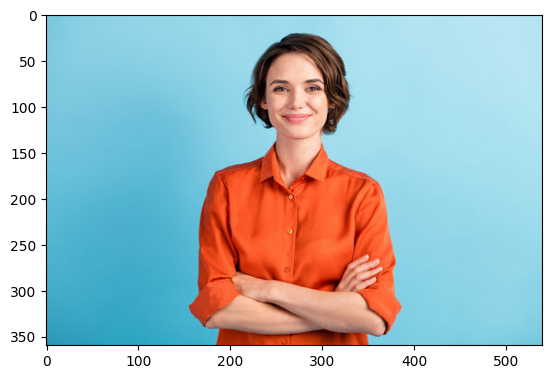

In [12]:
img_path='/kaggle/input/inputs/person1.jpg'
half = 0.5
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(image)
plt.show()

In [13]:
transform = transforms.Compose([transforms.ToTensor()])

In [14]:
img = transform(image)

In [15]:
pred = model([img])

In [16]:
pred[0]['labels']

tensor([1])

In [17]:
pred[0]['scores']

tensor([0.9996])

In [18]:
index=pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]

'person'

In [19]:
bounding_box=pred[0]['boxes'][0].tolist()
bounding_box

[155.96702575683594, 23.268478393554688, 394.4271240234375, 353.0426330566406]

In [20]:
t,l,r,b=[round(x) for x in bounding_box]

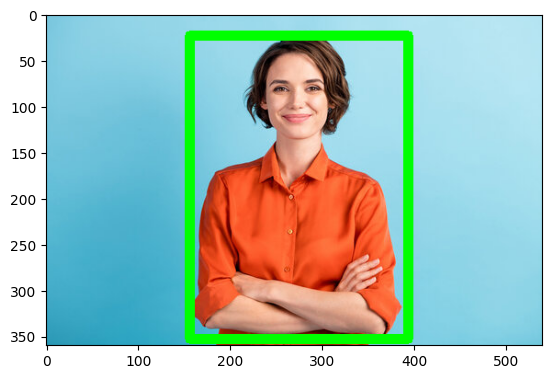

In [21]:
img_plot=(np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8)
cv2.rectangle(img_plot,(t,l),(r,b),(0, 255, 0), 10) # Draw Rectangle with the coordinates
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()
del img_plot,t,l,r,b

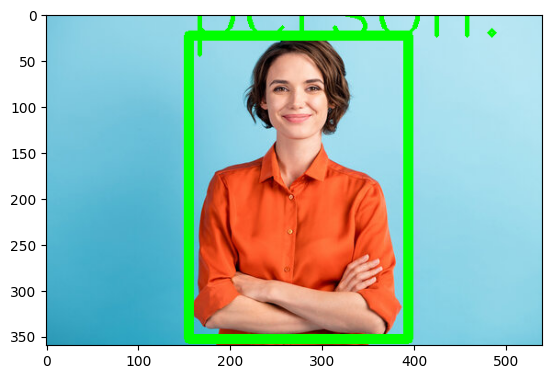

In [22]:
pred_class=get_predictions(pred,objects="person")
draw_box(pred_class, img)
del pred_class

In [23]:
get_predictions(pred,threshold=1,objects="person")

[]

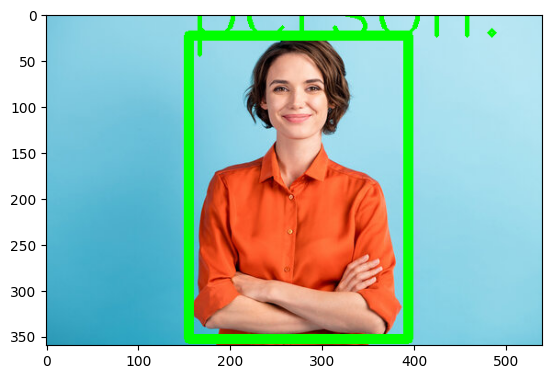

In [25]:
pred_thresh=get_predictions(pred,threshold=0.98,objects="person")
draw_box(pred_thresh,img)
del pred_thresh

In [26]:
save_RAM(image_=True)

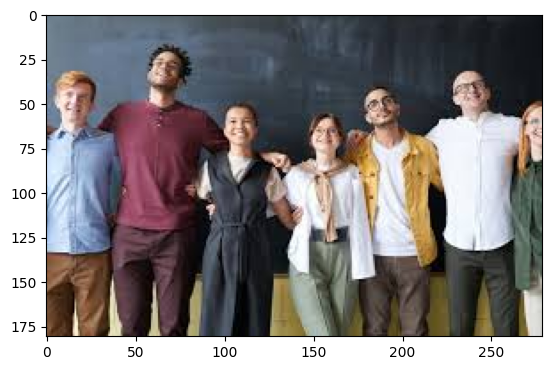

In [29]:
img_path='/kaggle/input/inputs/testimage1.jpeg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
plt.imshow(np.array(image))
plt.show()

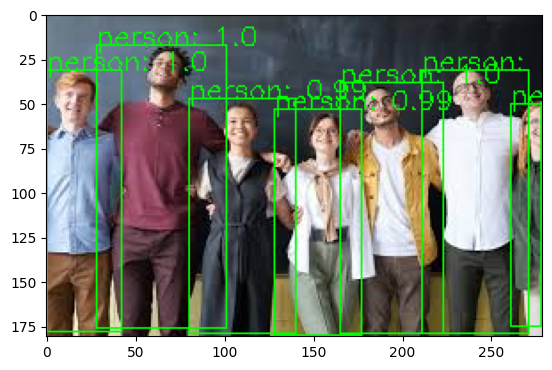

In [30]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.8,)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh

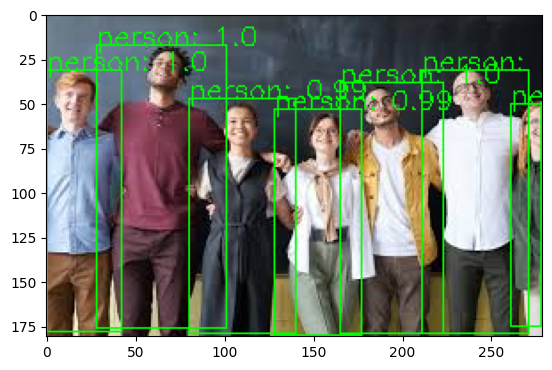

In [31]:
pred_obj=get_predictions(pred,objects="person")
draw_box(pred_obj,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_obj

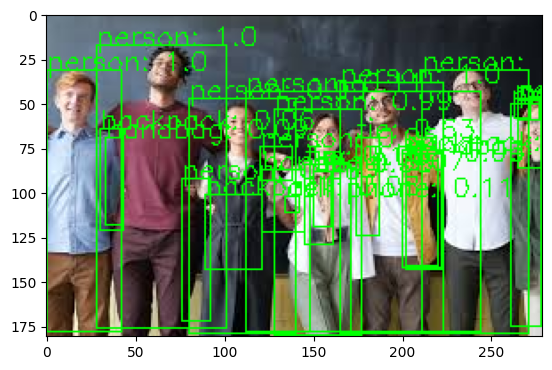

In [32]:
pred_thresh=get_predictions(pred,threshold=0.01)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh

In [33]:
save_RAM(image_=True)

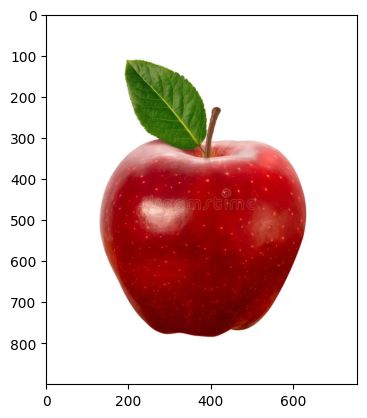

In [34]:
img_path='/kaggle/input/fruits/apple.jpeg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
plt.imshow(np.array(image))
plt.show()

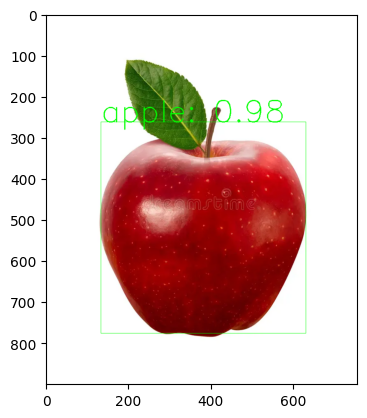

In [38]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.8,)
draw_box(pred_thresh,img,rect_th= 1,text_size= 2.5,text_th=2)
del pred_thresh